In [93]:
cd /private/home/ccaucheteux/hasson-syntaxe-vs-semantics/

/private/home/ccaucheteux/hasson-syntaxe-vs-semantics


In [94]:
import pandas as pd
import numpy as np
from src import paths

In [95]:
from nilearn import plotting
import nilearn
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

In [129]:
from mne.stats import fdr_correction
from scipy.stats import wilcoxon 

def get_pvals(r, corrected=True, alpha=0.05):
    # r of shape (dim, n_samples)
    pvals = [wilcoxon(x)[1] if not np.allclose(x, 0) else 1 for x in r]
    if corrected:
        pvals = fdr_correction(pvals, alpha=alpha, method='indep')[0]
    else:
        pvals = np.array(pvals)<=alpha
    return pvals

def set_ticks(ax, x_values = None, y_values = None):
    if x_values is not None:
        ax.set_xticks(x_values)
        ax.set_xticklabels([f"{x:.2f}".replace("0.", ".") for x in x_values])
    if y_values is not None:
        ax.set_yticks(y_values)
        ax.set_yticklabels([f"{x:.2f}".replace("0.", ".") for x in y_values])

In [130]:
import matplotlib.pyplot as plt
from scipy.stats import sem
import seaborn as sns

def gather_scores(scores):
    result = {}
    for d in scores:
        for k, v in d.items():
            if k in result:
                result[k].append(v)
            else:
                result[k] = [v]
        
    # Names
    names = result.keys()
    names = [p.name.split(".pth")[0] for p in names]
    scores = np.stack(list(result.values()))
    scores = np.transpose(scores, (0, 2, 1))
    return scores, names

In [131]:
def get_scores(exp_name):
    params = np.load(paths.scores / exp_name / "params.npy", allow_pickle=True).item()
    feature_labels = params["FEATURE_LABELS"]

    df_paths = pd.read_csv(paths.scores / exp_name / "results_path.csv")

    # Load scores
    from pathlib import Path
    df_paths["is_file"] = df_paths["save_file"].apply(lambda x : Path(x).is_file())
    df_paths = df_paths.query("is_file")

    temp = df_paths["save_file"].apply(lambda x : np.load(x, allow_pickle=True).item())
    is_not_none = np.array([i is not None for i in temp])
    df_paths = df_paths.query("@is_not_none")

    temp = temp[is_not_none]
    scores = np.stack([np.stack([np.stack(list(row[hemi].values())) for hemi in ["L", "R"]], axis=1) for row in temp], axis=1)
    #scores = {feature_labels[i] : scores[i] for i in range(len(scores))}
    del temp
    
    return scores, feature_labels


In [132]:
EXP_NAME = "single-subjects-0130"
EXP_NAME = "concat-single-subjects-0201"
EXP_NAME = "regressout-single-subjects-0209"
EXP_NAME = 'icml-review-concat-singlesubjects-[0206_wordembed]'
CONCAT = False

In [133]:
from pathlib import Path
df_path = pd.read_csv(paths.scores / EXP_NAME / "results_path.csv")
df_path["is_file"] = df_path.save_file.apply(lambda x : Path(x).is_file())
df_path = df_path.query("is_file")
df_path["both_hemi"] = df_path.groupby(["feature_file", "subject"])["hemi"].transform("count")==2
df_path = df_path.query("both_hemi")
df_path = df_path.sort_values("feature_file")

In [134]:
scores, names = {}, {}
for hemi in ["L", "R"]:
    temp = df_path.query("hemi==@hemi").save_file.apply(lambda x: np.load(x, allow_pickle=True))
    is_not_none = np.array([i is not None for i in temp])
    temp = temp[is_not_none]
    temp = [tp[0] for tp in temp]
    scores[hemi], names[hemi] = gather_scores(temp)

In [135]:
assert (np.array(names["L"]) == np.array(names["R"])).all()
scores = np.stack([scores["L"], scores["R"]], axis=1)
names = names["L"].copy()

In [136]:
if CONCAT:
    scores -= scores[0]

In [137]:
names

['3_phone_features',
 'phone_embedding_sum-gpt2-9.equiv-random-mean-10',
 'phone_sum-gpt2-0.equiv-random-mean-10',
 'phone_sum-gpt2-0',
 'phone_sum-gpt2-9.equiv-random-mean-10',
 'phone_sum-gpt2-9']

In [ ]:
k1 = 'phone_sum-gpt2-9'
k2 = 'phone_sum-gpt2-9.equiv-random-mean-10'
r = np.nanmean(scores[names.index(k1)] - scores[names.index(k2)], (0, 1))
print(np.nanmean(r), sem(r))

In [154]:
names.index(k)

4

In [163]:
k2

'phone_sum-gpt2-9.equiv-random-mean-10'

In [160]:
names.index(k2)

4

In [167]:
r = scores.mean((1, 2))
r2 = r[names.index(k2)] 
r1 = r[names.index(k1)]
idx = np.where(~np.isnan(r1) & ~np.isnan(r2))
r = r1[idx] - r2[idx]
print(np.nanmean(r), sem(r))

0.0042881018028173516 0.0007678661179255148


In [153]:
for k in [k1, k2]:
    r = scores.mean((1, 2))
    r = r[names.index(k1)] - r[names.index(k2)]
    r = np.nanmean(scores[names.index(k)], (0, 1))
    print(np.nanmean(r), sem(r))


0.013909240715579614 0.0005665463423626099
0.0096889025529695 0.00045592626058291603


In [151]:
k1 = 'phone_sum-gpt2-9'
k2 = 'phone_sum-gpt2-9.equiv-random-mean-10'
r = np.nanmean(scores[names.index(k1)] - scores[names.index(k2)], (0, 1))
print(np.nanmean(r), sem(r))

0.0042206499663170055 0.000758181103795519


In [ ]:
k1 = 'phone_sum-gpt2-9'
k2 = 'phone_sum-gpt2-9.equiv-random-mean-10'
r = np.nanmean(scores[names.index(k1)] - scores[names.index(k2)], (0, 1))
print(np.nanmean(r), sem(r))

In [ ]:
k1 = 'phone_sum-gpt2-9'
k2 = 'phone_sum-gpt2-9.equiv-random-mean-10'
r = np.nanmean(scores[names.index(k1)] - scores[names.index(k2)], (0, 1))
print(np.nanmean(r), sem(r))

In [141]:
k1 = 'phone_sum-gpt2-9'
k2 = 'phone_sum-gpt2-9.equiv-random-mean-10'
r = np.nanmean(scores, (1, 2))
r =  r[names.index(k2)] / r[names.index(k1)]


print(np.nanmean(r), sem(r))

0.16688631040282748 0.6766323459990469


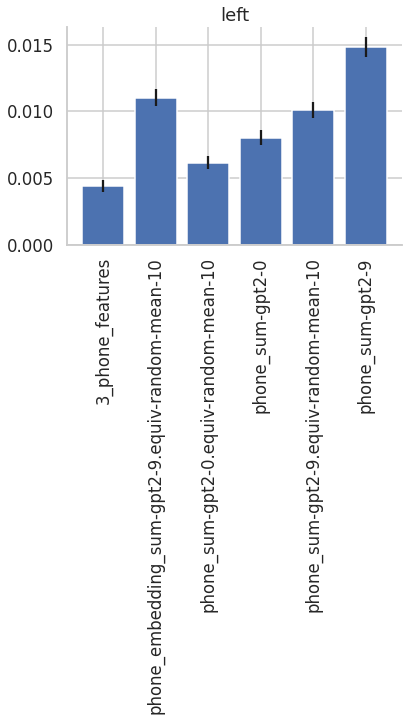

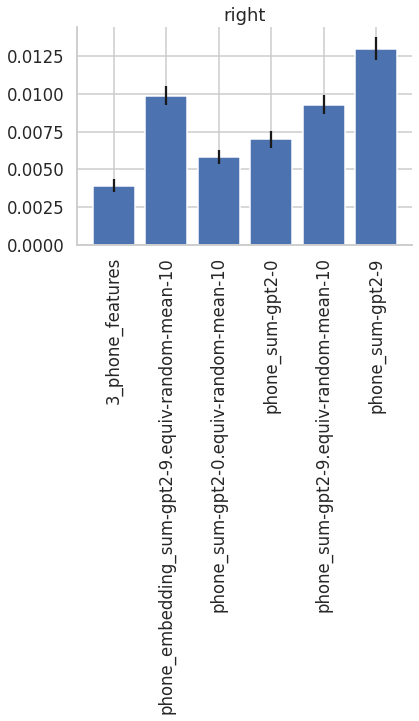

In [142]:
sns.set("talk", "whitegrid")

for i in range(2):
    r = scores[:,i]
    # Scores
    means = np.nanmean(np.nanmean(r, 1), -1)
    sems = sem(np.nanmean(r, 1), -1)

    # Plot
    plt.figure(facecolor="w")
    plt.bar(names, means, yerr=sems)
    plt.xticks(rotation="vertical")
    sns.despine()
    plt.title(["left", "right"][i])
    #set_ticks(ax, y_values=[0, .08])
    plt.show()

In [86]:
embed = names.index('phone_sum-gpt2-0')
embed_shuffle = names.index('phone_sum-gpt2-0.equiv-random-mean-10')
middle = names.index('phone_sum-gpt2-9')
middle_shuffle = names.index('phone_sum-gpt2-9.equiv-random-mean-10')
middle_shuffle_embed = names.index('phone_embedding_sum-gpt2-9.equiv-random-mean-10')


In [87]:
rows = ["Syntax", "Semantic", "Syntax + Semantics"]
cols = ["Lexical", "Compositional", "Lexical + Compositional"]


In [88]:
lab_embed = "X^{(0)}" #names.index('phone_sum-gpt2-0')
lab_embed_shuffle = "\overline{X^{(0)}}" 

lab_middle = "X^{(9)}" 
lab_middle_shuffle = "\overline{X^{(9)}}" 
lab_middle_shuffle_embed = "\overline{X^{(9)}} \oplus X^{(0)}"

labels = np.empty((len(rows), len(cols)), dtype="<U200")
labels[0, 0] = r"$\mathcal{R}(%s)$" % lab_embed_shuffle
labels[0, 1] = (r"$\mathcal{R}(%s)$" % lab_middle_shuffle) + "$-$" + (r"$\mathcal{R}(%s)$" % lab_embed_shuffle)
labels[0, 2] = r"$\mathcal{R}(%s)$" % lab_middle_shuffle

labels[1, 0] = (r"$\mathcal{R}(%s)$" % lab_embed) + r"$-$" + ( r"$\mathcal{R}(%s)$" % lab_embed_shuffle)
labels[1, 1] = (r"$\mathcal{R}(%s)$" % lab_middle) + r"$-$" + ( r"$\mathcal{R}(%s)$" % lab_middle_shuffle_embed)
labels[1, 2] = (r"$\mathcal{R}(%s)$" % lab_middle) + r"$-$" + ( r"$\mathcal{R}(%s)$" % lab_middle_shuffle)

labels[2, 0] = r"$\mathcal{R}(%s)$" % lab_embed
labels[2, 1] = (r"$\mathcal{R}(%s)$" % lab_middle) + r"$-$" + ( r"$\mathcal{R}(%s)$" % lab_embed)
labels[2, 2] = r"$\mathcal{R}(%s)$" % lab_middle

data = np.zeros((len(rows), len(cols), *scores.shape[1:]))
data[0, 0] = scores[embed_shuffle]
data[0, 1] = scores[middle_shuffle] - scores[embed_shuffle]
data[0, 2] = scores[middle_shuffle]

data[1, 0] = scores[embed] - scores[embed_shuffle]
data[1, 1] = scores[middle] - scores[middle_shuffle_embed]
data[1, 2] = scores[middle] - scores[middle_shuffle]

data[2, 0] = scores[embed]
data[2, 1] = scores[middle] - scores[embed]
data[2, 2] = scores[middle]

<ipython-input-89-bf5d43823d5c>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(G[0, j+1])


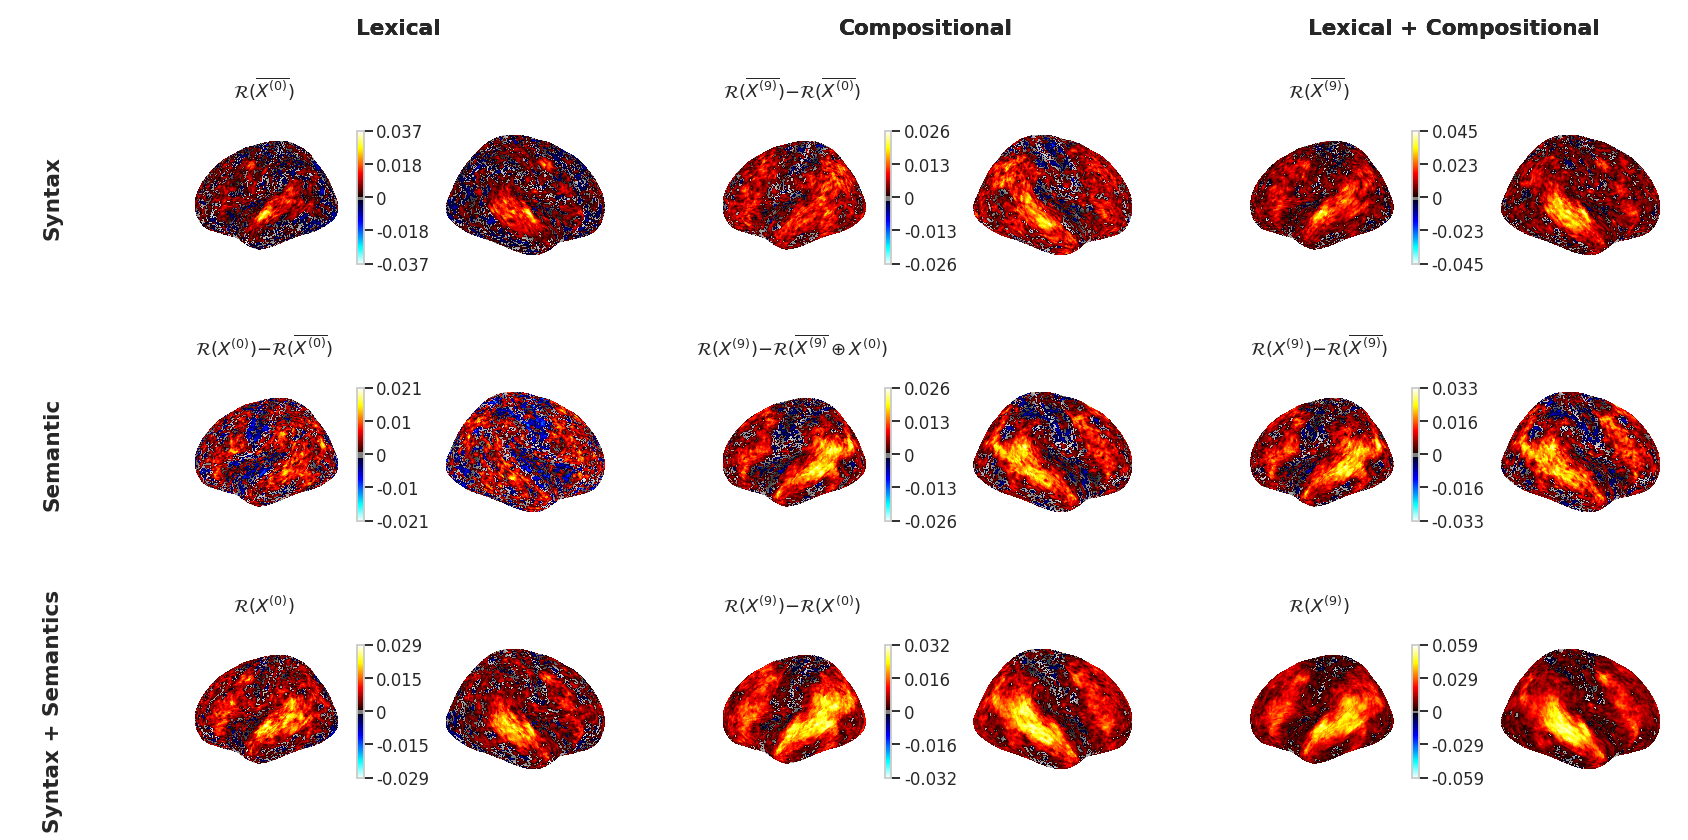

In [89]:
from matplotlib.gridspec import GridSpec, SubplotSpec

hemis = ["lh", "rh"]

fig = plt.figure(figsize=(30, 15), facecolor="w")
G = GridSpec(nrows=len(rows)+1, ncols=len(cols)+1, 
            height_ratios=[.2, 1, 1, 1], width_ratios=[.2, 1, 1, 1])
title_opts = dict(fontsize="large", verticalalignment="center",
            horizontalalignment="center", fontweight="bold")

for i, row in enumerate(rows):
    ax = plt.subplot(G[i+1, 0])
    plt.text(.5, .5, row, rotation=90, **title_opts)
    ax.axis("off")
    
    for j, col in enumerate(cols):
        
        ax = plt.subplot(G[0, j+1])
        plt.text(.5, .5, col, **title_opts)
        ax.axis("off")
        
        g0 = G[(i+1), (j+1)].subgridspec(nrows=1, ncols=2)
        
        for h, hemi in enumerate(["left", "right"]):
            r = data[i, j, h].mean(-1)
            
            ax = plt.subplot(g0[0, h], projection="3d")
            plotting.plot_surf_stat_map(
                surf_mesh = str(paths.surf_dir / f"{hemis[h]}.inflated"),
                stat_map = r,
                hemi=hemi,
                axes=ax,
                vmax=None, #. if "[-]" not in dico_labels[key] else None, 
                threshold=0.001,
                bg_map= str(paths.surf_dir / f"{hemis[h]}.sulc"),
                colorbar=(h==0),
                title=None if h==1 else labels[i, j],            
            )
            ax.set_zorder(-h)
            #set_ticks(ax, y_values=[r.min(), 0, r.max()])
            
plt.show()

<ipython-input-124-bf5d43823d5c>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(G[0, j+1])


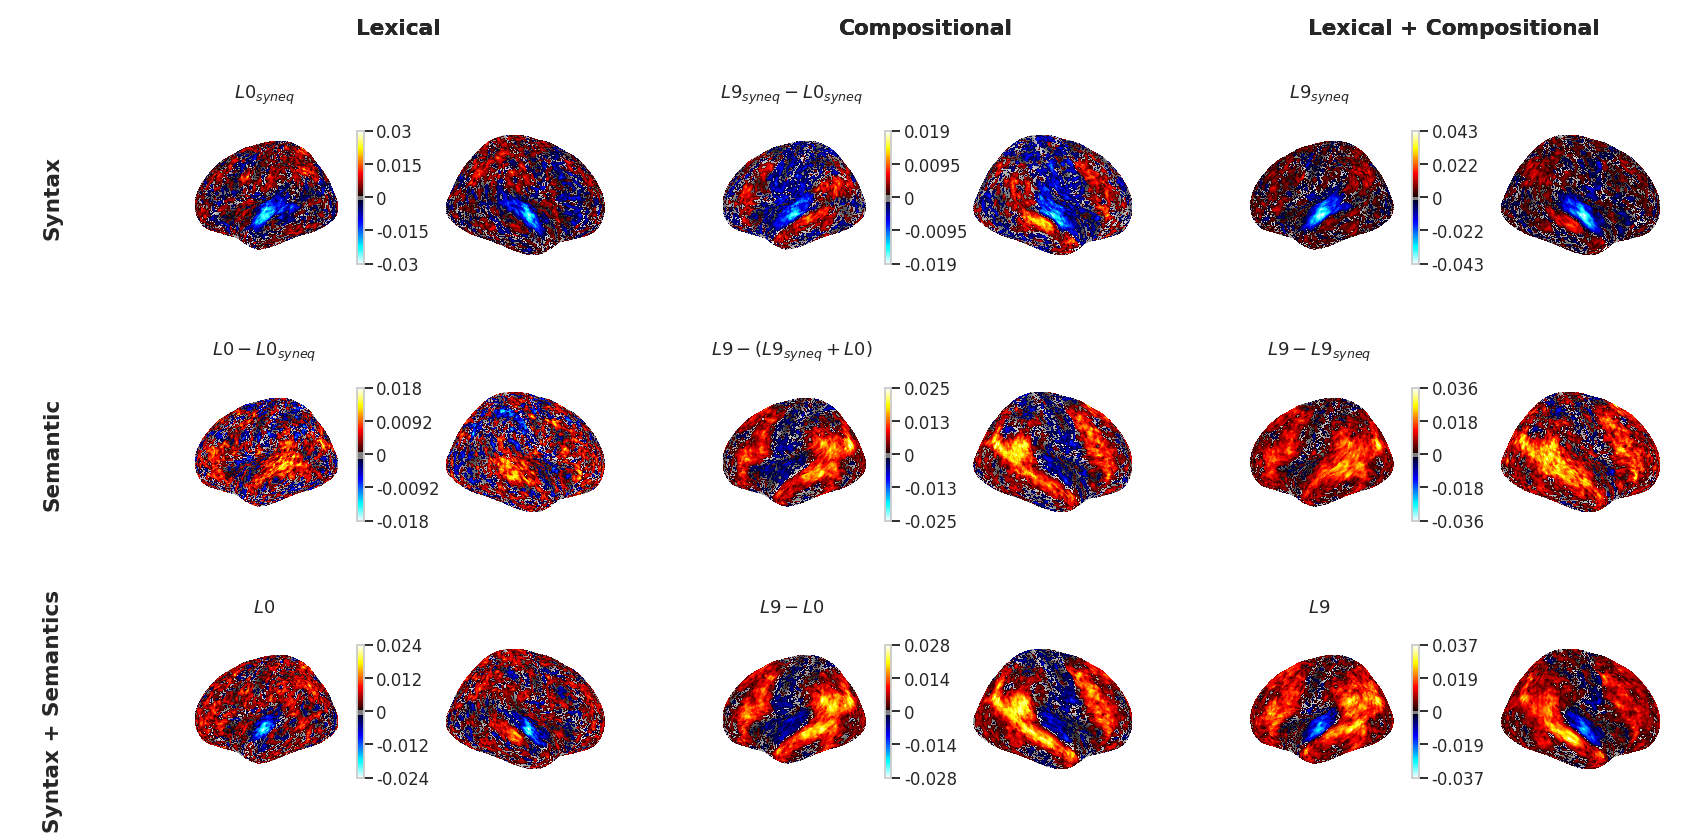

In [124]:
from matplotlib.gridspec import GridSpec, SubplotSpec

hemis = ["lh", "rh"]

fig = plt.figure(figsize=(30, 15), facecolor="w")
G = GridSpec(nrows=len(rows)+1, ncols=len(cols)+1, 
            height_ratios=[.2, 1, 1, 1], width_ratios=[.2, 1, 1, 1])
title_opts = dict(fontsize="large", verticalalignment="center",
            horizontalalignment="center", fontweight="bold")

for i, row in enumerate(rows):
    ax = plt.subplot(G[i+1, 0])
    plt.text(.5, .5, row, rotation=90, **title_opts)
    ax.axis("off")
    
    for j, col in enumerate(cols):
        
        ax = plt.subplot(G[0, j+1])
        plt.text(.5, .5, col, **title_opts)
        ax.axis("off")
        
        g0 = G[(i+1), (j+1)].subgridspec(nrows=1, ncols=2)
        
        for h, hemi in enumerate(["left", "right"]):
            r = data[i, j, h].mean(-1)
            
            ax = plt.subplot(g0[0, h], projection="3d")
            plotting.plot_surf_stat_map(
                surf_mesh = str(paths.surf_dir / f"{hemis[h]}.inflated"),
                stat_map = r,
                hemi=hemi,
                axes=ax,
                vmax=None, #. if "[-]" not in dico_labels[key] else None, 
                threshold=0.001,
                bg_map= str(paths.surf_dir / f"{hemis[h]}.sulc"),
                colorbar=(h==0),
                title=None if h==1 else labels[i, j],            
            )
            ax.set_zorder(-h)
            #set_ticks(ax, y_values=[r.min(), 0, r.max()])
            
plt.show()

In [90]:
import mne
subjects_dir = "../narratives/derivatives/freesurfer/"
all_labels = mne.read_labels_from_annot('fsaverage6', parc='aparc.a2009s', #parc='Yeo2011_17Networks_N1000', 
                                            subjects_dir=subjects_dir, verbose=False)

rois = {l.name : l.vertices for l in all_labels}
rois_colors = {"-".join(l.name.split("-")[:-1]) : l.color for l in all_labels if "lh" in l.name}

#areas = [i.split("-")[0] for i in rois.keys() if "Networks" in i]
areas = ["-".join(i.split("-")[:-1]) for i in rois.keys()] # if "Networks" in i]
areas = np.unique(areas)
results_rois = np.zeros((*data.shape[:3], len(areas), data.shape[-1]))
for i, area in enumerate(areas):
    for h, hemi in enumerate(["lh", "rh"]):
        results_rois[:, :, h, i] = data[:, :, h, rois[f"{area}-{hemi}"]].mean(-2)

data_pvals_rois = np.empty(list(results_rois.shape)[:-1], dtype=bool)
#results_rois.copy()
for i in range(data_pvals_rois.shape[0]):
    for j in range(data_pvals_rois.shape[1]):
        for h in range(data_pvals_rois.shape[2]): # Hemis
            pvals = get_pvals(results_rois[i, j, h], corrected=True, alpha=.05)
            data_pvals_rois[i, j, h] = pvals
            print(labels[i, j], pvals.sum()/len(pvals))

data_corrected = np.zeros(data.shape)
for i, area in enumerate(areas):
    for h, hemi in enumerate(["lh", "rh"]):
        vert = rois[f"{area}-{hemi}"]
        print(data_pvals_rois[:,:,h,i].sum()/len(data_pvals_rois[:,:,h,i]))
        idx = np.where(data_pvals_rois[:,:,h,i])
        test1 = data_corrected[:, :, h, vert].copy()
        test2 = data[:, :, h, vert].copy()
        test1[idx] = test2[idx]
        data_corrected[:, :, h, vert] = test1.copy()
        print(data_corrected[:, :, h, vert][data_pvals_rois[:,:,h,i]].sum())
        print(data[:, :, h, vert][data_pvals_rois[:,:,h,i]].sum())

$\mathcal{R}(\overline{X^{(0)}})$ 0.09333333333333334
$\mathcal{R}(\overline{X^{(0)}})$ 0.10666666666666667
$\mathcal{R}(\overline{X^{(9)}})$$-$$\mathcal{R}(\overline{X^{(0)}})$ 0.48
$\mathcal{R}(\overline{X^{(9)}})$$-$$\mathcal{R}(\overline{X^{(0)}})$ 0.32
$\mathcal{R}(\overline{X^{(9)}})$ 0.76
$\mathcal{R}(\overline{X^{(9)}})$ 0.68
$\mathcal{R}(X^{(0)})$$-$$\mathcal{R}(\overline{X^{(0)}})$ 0.0
$\mathcal{R}(X^{(0)})$$-$$\mathcal{R}(\overline{X^{(0)}})$ 0.0
$\mathcal{R}(X^{(9)})$$-$$\mathcal{R}(\overline{X^{(9)}} \oplus X^{(0)})$ 0.2
$\mathcal{R}(X^{(9)})$$-$$\mathcal{R}(\overline{X^{(9)}} \oplus X^{(0)})$ 0.08
$\mathcal{R}(X^{(9)})$$-$$\mathcal{R}(\overline{X^{(9)}})$ 0.37333333333333335
$\mathcal{R}(X^{(9)})$$-$$\mathcal{R}(\overline{X^{(9)}})$ 0.26666666666666666
$\mathcal{R}(X^{(0)})$ 0.36
$\mathcal{R}(X^{(0)})$ 0.24
$\mathcal{R}(X^{(9)})$$-$$\mathcal{R}(X^{(0)})$ 0.8266666666666667
$\mathcal{R}(X^{(9)})$$-$$\mathcal{R}(X^{(0)})$ 0.76
$\mathcal{R}(X^{(9)})$ 0.9333333333333333
$\mat

In [92]:
scores.shape

(6, 2, 40962, 305)

<ipython-input-91-889deb491b10>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(G[0, j+1])
/private/home/ccaucheteux/.conda/envs/hasson/lib/python3.8/site-packages/nilearn/plotting/surf_plotting.py:265: RuntimeWarning: invalid value encountered in true_divide
  surf_map_faces = surf_map_faces / (vmax - vmin)
/private/home/ccaucheteux/.conda/envs/hasson/lib/python3.8/site-packages/nilearn/plotting/surf_plotting.py:297: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  cbar = figure.colorbar(
/private/home/ccaucheteux/.conda/envs/hasson/lib/python3.8/site-packages/nilearn/plotting/surf_plotting.py:297: UserWarning: 

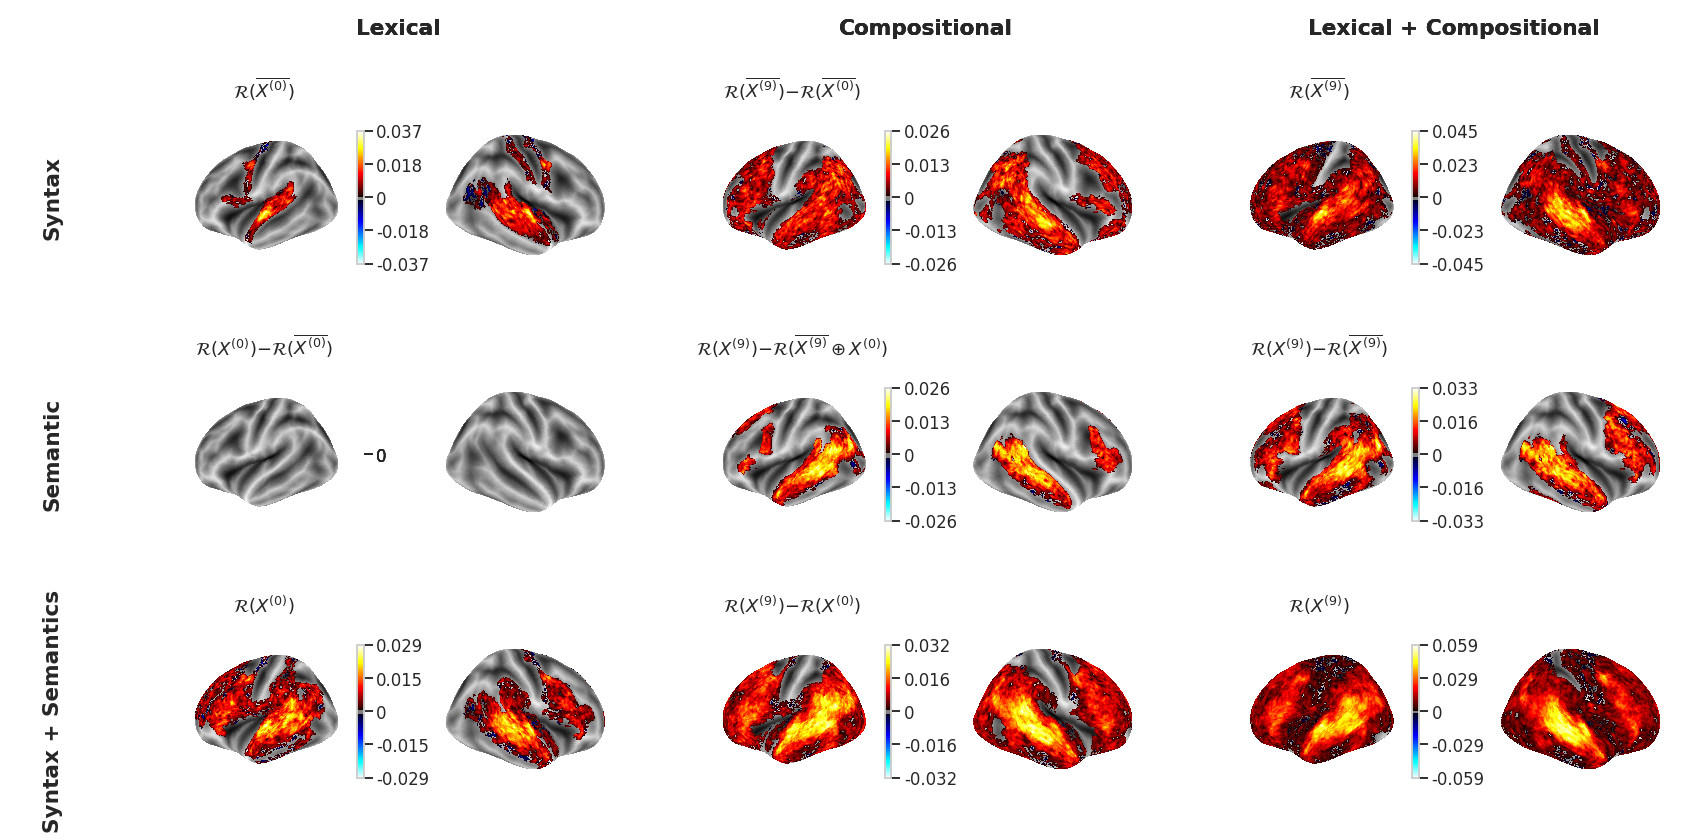

In [91]:
from matplotlib.gridspec import GridSpec, SubplotSpec

hemis = ["lh", "rh"]

fig = plt.figure(figsize=(30, 15), facecolor="w")
G = GridSpec(nrows=len(rows)+1, ncols=len(cols)+1, 
            height_ratios=[.2, 1, 1, 1], width_ratios=[.2, 1, 1, 1])
title_opts = dict(fontsize="large", verticalalignment="center",
            horizontalalignment="center", fontweight="bold")

for i, row in enumerate(rows):
    ax = plt.subplot(G[i+1, 0])
    plt.text(.5, .5, row, rotation=90, **title_opts)
    ax.axis("off")
    
    for j, col in enumerate(cols):
        
        ax = plt.subplot(G[0, j+1])
        plt.text(.5, .5, col, **title_opts)
        ax.axis("off")
        
        g0 = G[(i+1), (j+1)].subgridspec(nrows=1, ncols=2)
        
        for h, hemi in enumerate(["left", "right"]):
            r = data_corrected[i, j, h].mean(-1)
            
            ax = plt.subplot(g0[0, h], projection="3d")
            plotting.plot_surf_stat_map(
                surf_mesh = str(paths.surf_dir / f"{hemis[h]}.inflated"),
                stat_map = r,
                hemi=hemi,
                axes=ax,
                vmax=None, #. if "[-]" not in dico_labels[key] else None, 
                threshold=0.001,
                bg_map= str(paths.surf_dir / f"{hemis[h]}.sulc"),
                colorbar=(h==0),
                title=None if h==1 else labels[i, j],            
            )
            ax.set_zorder(-h)
            #set_ticks(ax, y_values=[r.min(), 0, r.max()])
            
plt.show()

<ipython-input-29-889deb491b10>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(G[0, j+1])


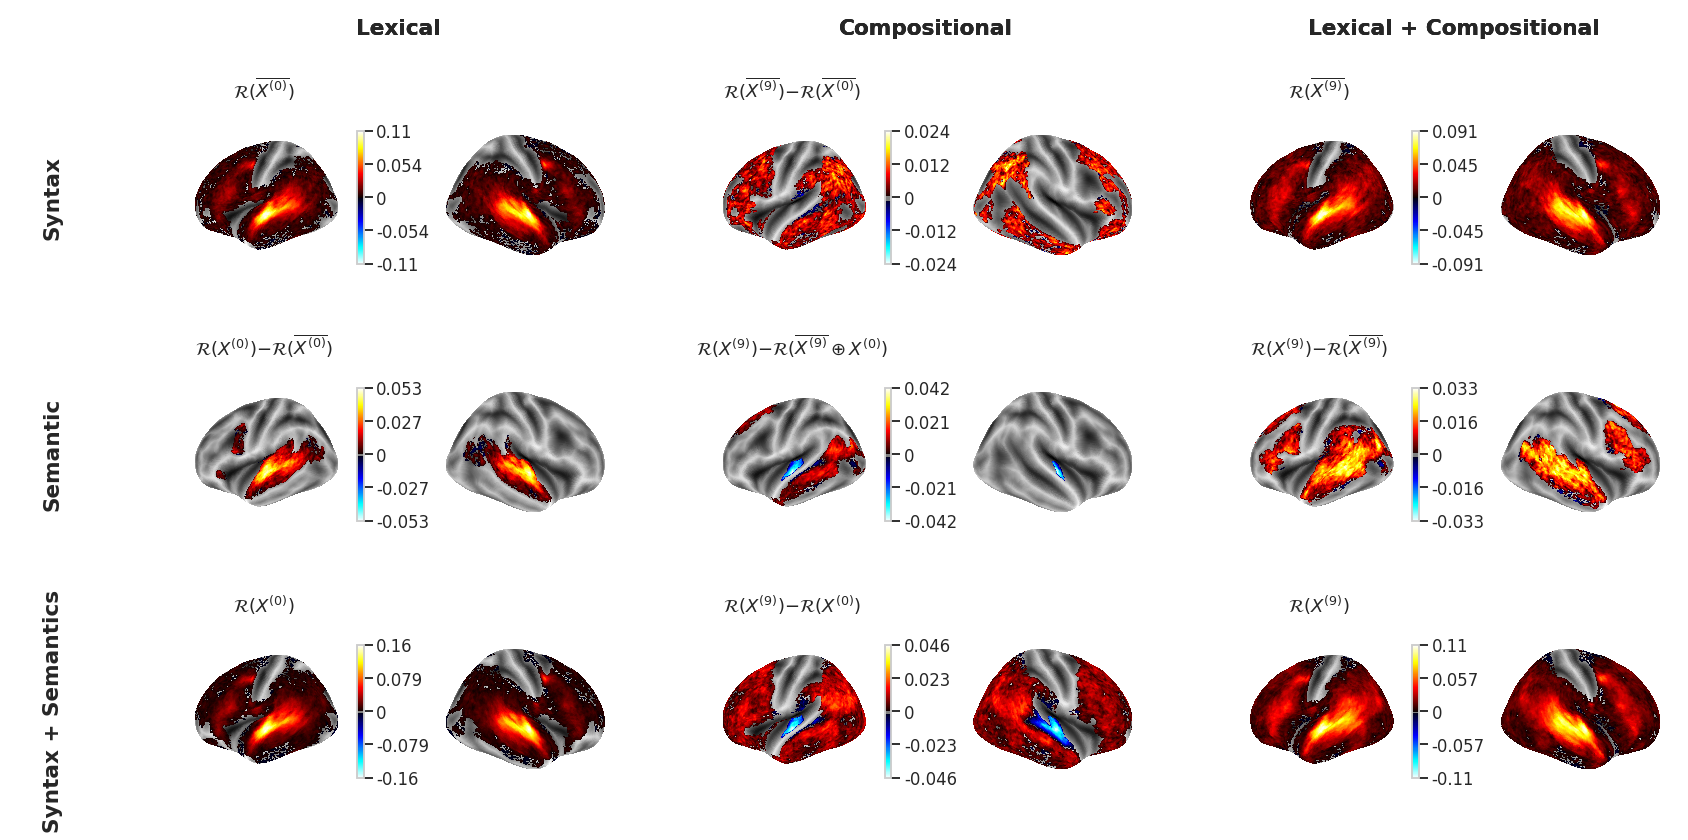

In [29]:
from matplotlib.gridspec import GridSpec, SubplotSpec

hemis = ["lh", "rh"]

fig = plt.figure(figsize=(30, 15), facecolor="w")
G = GridSpec(nrows=len(rows)+1, ncols=len(cols)+1, 
            height_ratios=[.2, 1, 1, 1], width_ratios=[.2, 1, 1, 1])
title_opts = dict(fontsize="large", verticalalignment="center",
            horizontalalignment="center", fontweight="bold")

for i, row in enumerate(rows):
    ax = plt.subplot(G[i+1, 0])
    plt.text(.5, .5, row, rotation=90, **title_opts)
    ax.axis("off")
    
    for j, col in enumerate(cols):
        
        ax = plt.subplot(G[0, j+1])
        plt.text(.5, .5, col, **title_opts)
        ax.axis("off")
        
        g0 = G[(i+1), (j+1)].subgridspec(nrows=1, ncols=2)
        
        for h, hemi in enumerate(["left", "right"]):
            r = data_corrected[i, j, h].mean(-1)
            
            ax = plt.subplot(g0[0, h], projection="3d")
            plotting.plot_surf_stat_map(
                surf_mesh = str(paths.surf_dir / f"{hemis[h]}.inflated"),
                stat_map = r,
                hemi=hemi,
                axes=ax,
                vmax=None, #. if "[-]" not in dico_labels[key] else None, 
                threshold=0.001,
                bg_map= str(paths.surf_dir / f"{hemis[h]}.sulc"),
                colorbar=(h==0),
                title=None if h==1 else labels[i, j],            
            )
            ax.set_zorder(-h)
            #set_ticks(ax, y_values=[r.min(), 0, r.max()])
            
plt.show()

In [128]:
text = ["\n", " ",
" -- ", ". ",
" – ", ", ",
"–", "-",
' "', ". ",
' "', ". ",
'" ', ". ",
'". ', ". ",
'." ', ". ",
"?. ", "? ",
",. ", ", ",
"...", ". ",
".. ", ". ",
":", ". ",
"…", ". ",
"-", " ",
"  ", " ",]
np.unique(text)

array(['\n', ' ', '  ', ' "', ' -- ', ' – ', '" ', '". ', ', ', ',. ',
       '-', '. ', '." ', '.. ', '...', ':', '? ', '?. ', '–', '…'],
      dtype='<U4')

In [129]:
np.unique([i.strip() for i in text])

array(['', '"', '".', ',', ',.', '-', '--', '.', '."', '..', '...', ':',
       '?', '?.', '–', '…'], dtype='<U3')